# Experiment 4: Dataset Scaling Test
### Evaluating HQNN Performance Across Increasingly Complex Datasets

In [1]:
# Setup and Imports
import sys
sys.path.append("..")

import torch
from torch import nn, optim
from qiskit.visualization import circuit_drawer
from hqnn_core.qnn_builder import create_qnn
from hqnn_core.classical_model import ClassicalNN
from hqnn_core.hqnn_model import HybridModel
from hqnn_core.train import train_model
from hqnn_core.evaluate import evaluate_model
from hqnn_core.data_utils import load_rssi_dataset
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
# Experiment Configs
num_qubits = 3
reps = 1
feature_map_type = "zz"
ansatz_type = "real"
batch_size = 1
num_epochs = 20
learning_rate = 0.01

scenario_to_number = {
    "scenario_one": "1",
    "scenario_two": "2",
    "scenario_three": "3"
}

scenario_sets = [
    ["scenario_one"],
    ["scenario_one", "scenario_two"],
    ["scenario_one", "scenario_two", "scenario_three"]
]

In [ ]:
# Model Training
results = []

for set_idx, scenarios in enumerate(scenario_sets):
    print(f"\nTesting Scenario Set {set_idx + 1}: {scenarios}")
    
    # Load data from all scenarios in this set
    train_loaders, test_loaders = [], []
    for sc in scenarios:
        for signal in ["bluetooth", "wifi", "zigbee"]:
            tl, tstl = load_rssi_dataset(
                scenario=sc,
                signal=signal,
                sc_num=scenario_to_number[sc],
                batch_size=batch_size,
                base_path="../data"
            )
            train_loaders.append(tl)
            test_loaders.append(tstl)

    # Combine all data
    combined_train_loader = torch.utils.data.DataLoader(
        torch.utils.data.ConcatDataset([dl.dataset for dl in train_loaders]),
        batch_size=batch_size, shuffle=True
    )
    combined_test_loader = torch.utils.data.DataLoader(
        torch.utils.data.ConcatDataset([dl.dataset for dl in test_loaders]),
        batch_size=batch_size, shuffle=False
    )

    # Create model
    qnn = create_qnn(num_qubits, reps, feature_map_type, ansatz_type)
    clnn = ClassicalNN(input_size=3, hidden_size=32, output_size=2)
    model = HybridModel(qnn, clnn)

    # Train
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    train_model(model, combined_train_loader, criterion, optimizer, num_epochs, verbose=True)

    # Evaluate
    rmse = evaluate_model(model, combined_test_loader)
    results.append({"Scenario_Combination": "+".join(scenarios), "RMSE": rmse})


📦 Testing Scenario Set 1: ['scenario_one']
Epoch 1/20 - Loss: 7.4354
Epoch 2/20 - Loss: 1.8596
Epoch 3/20 - Loss: 2.1222
Epoch 4/20 - Loss: 1.8280
Epoch 5/20 - Loss: 1.5450
Epoch 6/20 - Loss: 1.1333
Epoch 7/20 - Loss: 1.1490
Epoch 8/20 - Loss: 0.9178
Epoch 9/20 - Loss: 1.1036
Epoch 10/20 - Loss: 0.9880
Epoch 11/20 - Loss: 0.9245
Epoch 12/20 - Loss: 0.7821
Epoch 13/20 - Loss: 0.8300
Epoch 14/20 - Loss: 0.8945
Epoch 15/20 - Loss: 0.8014
Epoch 16/20 - Loss: 0.7612
Epoch 17/20 - Loss: 0.8366
Epoch 18/20 - Loss: 0.8180
Epoch 19/20 - Loss: 0.7982
Epoch 20/20 - Loss: 0.8794
✅ RMSE on test set: 1.3922

📦 Testing Scenario Set 2: ['scenario_one', 'scenario_two']
Epoch 1/20 - Loss: 7.5739
Epoch 2/20 - Loss: 3.2350
Epoch 3/20 - Loss: 2.0734
Epoch 4/20 - Loss: 2.1903
Epoch 5/20 - Loss: 1.6637
Epoch 6/20 - Loss: 1.6270
Epoch 7/20 - Loss: 1.3992
Epoch 8/20 - Loss: 1.2206
Epoch 9/20 - Loss: 1.2078
Epoch 10/20 - Loss: 1.1439
Epoch 11/20 - Loss: 1.1172
Epoch 12/20 - Loss: 1.1253
Epoch 13/20 - Loss: 1.1

In [ ]:
# Results
df_results = pd.DataFrame(results)
df_results.reset_index(drop=True, inplace=True)
df_results.to_csv("dataset_scaling_table.csv", index=False)
df_results

,Scenario_Combination,RMSE
0,scenario_one+scenario_two,1.121199
1,scenario_one,1.392224
2,scenario_one+scenario_two+scenario_three,2.075183


/var/folders/vj/03h5j0rn0_j_4l1135jfjp880000gn/T/ipykernel_75280/942426540.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


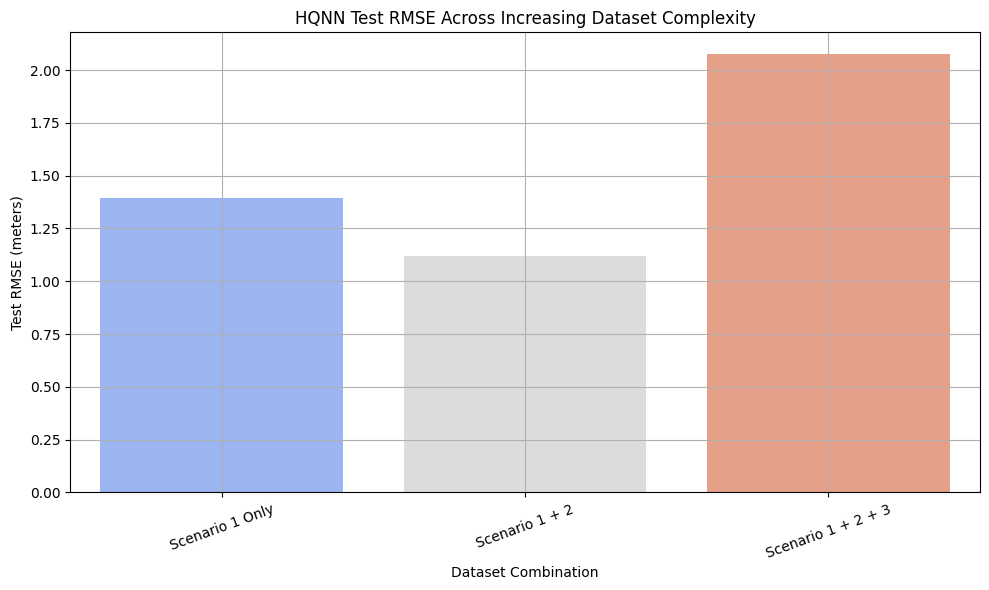

In [6]:
import seaborn as sns

rename_mapping = {
    "scenario_one": "Scenario 1 Only",
    "scenario_one+scenario_two": "Scenario 1 + 2",
    "scenario_one+scenario_two+scenario_three": "Scenario 1 + 2 + 3"
}
df_results["Scenario_Display"] = df_results["Scenario_Combination"].map(rename_mapping)
scenario_display_order = ["Scenario 1 Only", "Scenario 1 + 2", "Scenario 1 + 2 + 3"]

plt.figure(figsize=(10, 6))
sns.barplot(
    data=df_results,
    x="Scenario_Display", y="RMSE",
    palette="coolwarm",
    order=scenario_display_order  
)
plt.title("HQNN Test RMSE Across Increasing Dataset Complexity")
plt.xlabel("Dataset Combination")
plt.ylabel("Test RMSE (meters)")
plt.xticks(rotation=20)
plt.grid(True)
plt.tight_layout()

plt.savefig("dataset_scaling_rmse_ordered.pdf", format="pdf", dpi=300, bbox_inches="tight")

plt.show()
